# Importing Libraries & CSV

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('default')

# Star identification (can be modified as needed)
#TIC, star = 'TIC 276252961', 'BH Lyn'
TIC, star = 'TIC 243247640', 'DV Uma'
current_star = star + " (" + TIC + ")"
cadence_magnifier = 10
cadence = 120
no_test_chunks = 100000

# Read data from CSV file
def read_csv_data(filename):
    """
    Read lightcurve data from CSV file.
    Expected columns: 'time' (in JD) and 'flux' (normalized flux values)
    """
    try:
        df = pd.read_csv(filename)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        
        print(f"Available columns: {list(df.columns)}")
        print(f"First few rows:\n{df.head()}")
        
        # Check for required columns (case insensitive)
        time_col = None
        flux_col = None
        
        for col in df.columns:
            if col.lower() in ['time', 'jd', 'bjd', 'hjd']:
                time_col = col
            elif col.lower() in ['flux', 'magnitude', 'mag', 'brightness']:
                flux_col = col
        
        if time_col is None or flux_col is None:
            print(f"Available columns: {list(df.columns)}")
            raise ValueError("Could not find time and flux columns in CSV")
        
        print(f"Using columns: {time_col} (time), {flux_col} (flux)")
        
        # Convert to numeric, coercing errors to NaN
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df[flux_col] = pd.to_numeric(df[flux_col], errors='coerce')
        
        # Remove NaN values and any rows with non-numeric data
        df = df[[time_col, flux_col]].dropna()
        
        # Ensure we have data after cleaning
        if len(df) == 0:
            raise ValueError("No valid numeric data found after cleaning")
        
        # Convert magnitude to flux if needed (assuming magnitude column)
        if flux_col.lower() in ['magnitude', 'mag']:
            # Convert magnitude to relative flux (higher mag = lower flux)
            flux_values = 10**(-0.4 * (df[flux_col] - df[flux_col].median()))
        else:
            flux_values = df[flux_col].values
        
        # Ensure data is in proper numeric format for lightkurve
        time_values = np.array(df[time_col].values, dtype=np.float64)
        flux_values = np.array(flux_values, dtype=np.float64)
        
        # Remove any infinite values
        finite_mask = np.isfinite(time_values) & np.isfinite(flux_values)
        time_values = time_values[finite_mask]
        flux_values = flux_values[finite_mask]
        
        print(f"Loaded {len(time_values)} valid data points from {filename}")
        print(f"Time range: {time_values.min():.2f} to {time_values.max():.2f}")
        print(f"Flux range: {flux_values.min():.6f} to {flux_values.max():.6f}")
        
        return time_values, flux_values
        
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        raise


C:\Users\kterp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


Available columns: ['JD', 'Magnitude']
First few rows:
             JD Magnitude
0  2.452375e+06    14.612
1  2.452375e+06    14.535
2  2.452375e+06    14.595
3  2.452375e+06    14.481
4  2.452375e+06    14.627
Using columns: JD (time), Magnitude (flux)
Loaded 6212 valid data points from aavso_data.csv
Time range: 2452374.54 to 2459995.40
Flux range: 0.009607 to 2.503802
Created 1 lightcurve segments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6212 entries, 0 to 6211
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    6212 non-null   float64
 1   flux    6212 non-null   float64
dtypes: float64(2)
memory usage: 97.2 KB


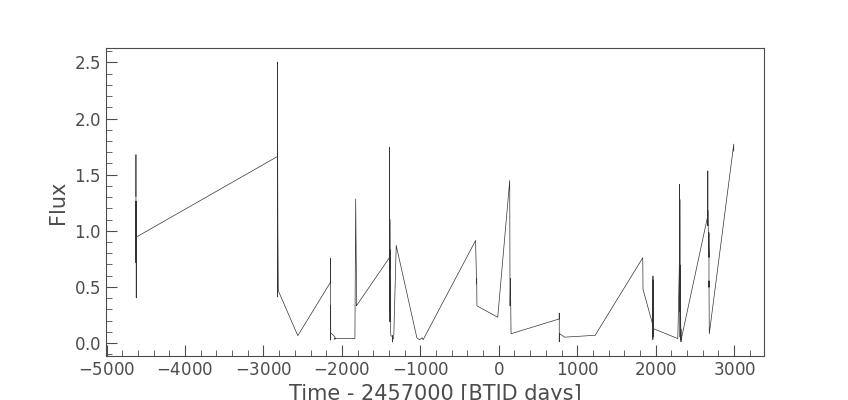

In [2]:
# Function to create lightcurve objects from CSV data
def create_lightcurves_from_csv(filename, chunk_size=None):
    """
    Create lightkurve LightCurve objects from CSV data.
    If chunk_size is provided, split data into chunks to simulate multiple sectors.
    """
    time_data, flux_data = read_csv_data(filename)
    
    lcs = []
    
    if chunk_size is None or len(time_data) <= chunk_size:
        # Create single lightcurve with explicit astropy units
        lc = lk.LightCurve(time=time_data, flux=flux_data, 
                          time_format='jd', flux_unit='electron/s')
        lcs.append(lc)
    else:
        # Split into chunks to simulate multiple sectors
        num_chunks = len(time_data) // chunk_size
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(time_data))
            
            chunk_time = time_data[start_idx:end_idx]
            chunk_flux = flux_data[start_idx:end_idx]
            
            lc = lk.LightCurve(time=chunk_time, flux=chunk_flux,
                              time_format='jd', flux_unit='electron/s')
            lcs.append(lc)
        
        # Add remaining data if any
        if len(time_data) % chunk_size != 0:
            remaining_time = time_data[num_chunks * chunk_size:]
            remaining_flux = flux_data[num_chunks * chunk_size:]
            lc = lk.LightCurve(time=remaining_time, flux=remaining_flux,
                              time_format='jd', flux_unit='electron/s')
            lcs.append(lc)
    
    print(f"Created {len(lcs)} lightcurve segments")
    return lcs

# Load data from CSV file instead of TESS archive
try:
    lcs = create_lightcurves_from_csv('aavso_data.csv', chunk_size=10000)  # Adjust chunk_size as needed
    lightcurve = combine_lightcurves(lcs)
    lightcurve.plot()
except Exception as e:
    print(f"Failed to load data: {e}")
    print("Please ensure 'aavso_data.csv' exists and contains 'time' and 'flux' columns")
    # Exit or provide alternative data loading method
    raise



# Preparing Lightcurves for Analysis 

In [3]:
#Preparing the Lightcurves for analysis
new_lcs = []

for lc in lcs:  
    # Removing Nans from the Lightcurves
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    # Remove duplicate or nearly-duplicate time values and sort by time
    df = df.drop_duplicates(subset='time').sort_values('time')
    new_lc = lk.LightCurve(time=df['time'], flux=df['flux'])

    # new_lc = lc.remove_nans()                  #Potential alternative solution

    # Removing the big trends AND increasing the cadence.
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want='lc', displaygraphs=False, window_length_for_remove=(3600*50)/120, iterations=3)
    try:
        new_lc = spline_while_jumping_gaps(new_lc, cadence_magnifier=cadence_magnifier)
        # Storing away the adjusted & splined curve
        new_lcs.append(new_lc)
    except ValueError as e:
        print(f"Skipping problematic segment due to error: {e}")

lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot(color = '#7B81FD', alpha = 0.5, lw = 0.5, ylabel = 'Normalized Flux')

#IMPORTANT Note: The straight lines between gaps seen below are not present in the data, Python adds them just for the graphs to make them visually continuous. The data is not continuous for that part.




Gaps at times: [-4625.36809924 -4624.54852924 -4621.51838924 -2821.62439924
 -2821.44609924 -2820.36209924 -2562.25119927 -2144.42561925
 -2142.65919925 -2089.53347924 -1824.22852927 -1815.54380926
 -1812.55792926 -1392.69968925 -1391.49581925 -1391.23969925
 -1388.22417625 -1376.28096924 -1307.49043924  -964.61623924
  -290.65719924  -281.57919924  -278.64019924   156.40880076
   771.08601075   771.76279075   771.92693075  1228.40580076
  1838.44080074  1964.57862076  1965.52438076  1967.42684076
  2304.40380076  2305.40180076  2306.47680076  2307.44180076
  2308.56619076  2309.37280076  2310.54300076  2311.44080076
  2312.39382076  2317.40480076  2320.40680076  2324.39280076
  2664.49200076  2683.39280076]
[ 136  205  346  426  595 1180 2855 3043 3046 3051 3057 3062 3064 3112
 3259 3555 4033 4036 4154 4158 4160 4163 4165 4170 4688 4785 4788 4797
 4799 5000 5283 5324 5328 5331 5335 5338 5568 5572 5778 5780 5782 5834
 5836 6051 6101 6157 6159]
Splining values between  -4625.45926924003

ValueError: need at least one array to concatenate

# Periodogram

Guessed peak width is 6.560939858943011e-05
762085


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': '3538b195-5bbd-44ba-9c4c-dc34239c94af',
              'x': {'bdata': ('MZnXTwiMID8/RMwT6RE0PyiSBclCjj' ... '60nv8zQCfYuR+t/zNAvj8KctT/M0A='),
                    'dtype': 'f8'},
              'y': {'bdata': ('okb6kR0m5T9Cr2/RWjLbPzxHz1sG0O' ... 'p+OKWzPyqCRAcDNbQ/mOsJv/vfsT8='),
                    'dtype': 'f8'}},
             {'line': {'color': 'black'},
              'mode': 'lines',
              'name': 'Periodogram',
              'type': 'scatter',
              'uid': '749cb9df-54a6-447c-94d8-12d095a2e632',
              'x': {'bdata': ('cr5/asGE+z5yvn9qwYQLP9bO3w+Rox' ... 'jy+v8zQPv9JKv8/zNAoxRxY/7/M0A='),
                    'dtype': 'f8'},
              'y': {'bdata': ('Cscg4WM94j8j80TEA9XiP72qfvRNzO' ... 'RY13muPxJzbZ0i8rE/+NUH1NREtD8='),
                    'dtype': 'f8'}}],
    'layout': {'

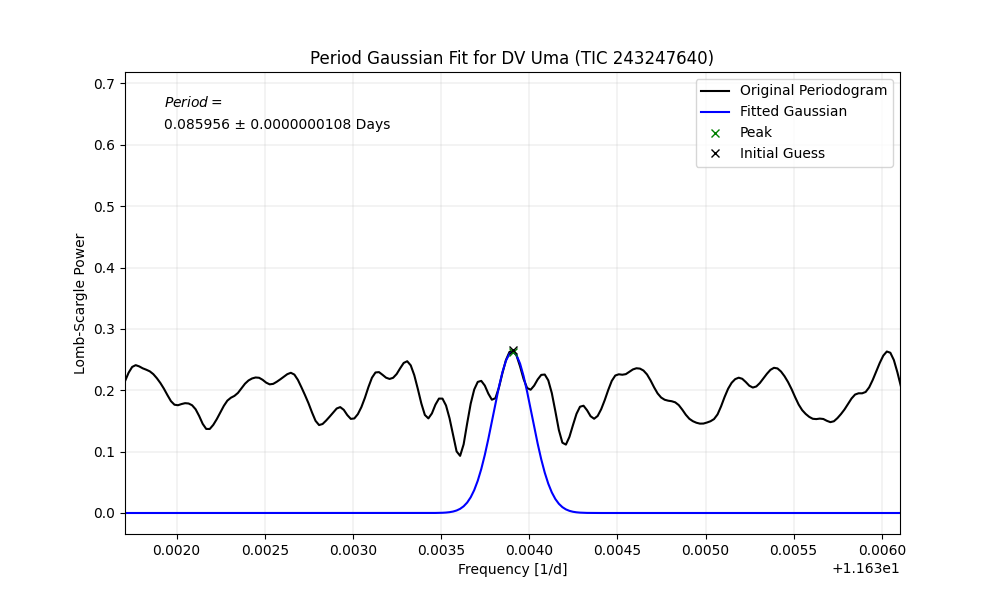

In [4]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 20)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(f'Guessed peak width is {peak_width}')
max_power = periodogram.max_power.value
optimized_parameters_global = []

frequencies = periodogram.frequency.value
print(len(frequencies))
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})
periodogram_df = pd.DataFrame({'frequencies': f, 'power': p})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

global_periods_uncertainities = []
global_periods = []

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        point_freq = peaks_df['frequencies'][i]

        zoomed_df = periodogram_df[periodogram_df['frequencies'].between(point_freq - (1.5*peak_width), point_freq + (1.5*peak_width))]

        optimized_parameters, covariance = optimize.curve_fit(gaussian, zoomed_df['frequencies'], zoomed_df['power'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)
        fitted_gaussian_again = gaussian(f, amp, cen, wid)

        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])


        fig, ax = plt.subplots(figsize = (10, 6))
        ax.plot(f, p, label = "Original Periodogram", color = 'black')
        # ax.plot(zoomed_df['frequencies'], zoomed_df['power'], label = "Zoomed Periodogram", color = 'red')
        ax.plot(f, fitted_gaussian_again, label = 'Fitted Gaussian', color = 'blue')
        ax.plot(cen, amp, 'x', label = 'Peak', color = 'green')        
        ax.plot(initial_guess[1], initial_guess[0], 'x', label = 'Initial Guess', color = 'black')
        ax.set_xlim(cen - 20*wid, cen + 20*wid)
        ax.set_title(f'Period Gaussian Fit for {current_star}')
        ax.set_xlabel('Frequency [1/d]')
        ax.set_ylabel('Lomb-Scargle Power')


        period_uncertainity = float(np.sqrt(covariance[1, 1]))/(cen**2)
        global_periods_uncertainities.append(period_uncertainity)
        global_periods.append(1/cen)

        period_here = f"{round(1/cen, 6)} ± {period_uncertainity:.10f} Days"

        print(f'Period is {1/cen} ± {period_uncertainity:.10f} Days')
        print("Ucertainity in seconds is ", period_uncertainity*24*60*60)

        plt.text(0.05, 0.95, f'$Period =$', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')
        plt.text(0.05, 0.90, f'{round(1/cen, 6)} ± {period_uncertainity:.10f} Days', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')
        

        ax.grid(True, linewidth = 0.2)
        ax.legend(loc = 'upper right')
    
scatter.on_click(update_point)
fi


In [5]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

old_fitted_period = fitted_period.copy()

Fitted Frequency: 11.633905386952353
Fitted Period: 0.08595565863218374


# Dividing Data Into Chunks

In [6]:
# Dividing the lightcurve into chunks, the size of a chunk is the fitted period.
# Fixed to work with both TESS and CSV data

# Check what time format is available and use appropriate one
try:
    # Try TESS format first (btjd)
    time_data = lightcurve.time.btjd
    time_format = "btjd"
    print("Using TESS btjd time format")
except AttributeError:
    try:
        # Try regular Julian Date
        time_data = lightcurve.time.jd
        time_format = "jd" 
        print("Using Julian Date time format")
    except AttributeError:
        # Fallback to raw time values
        time_data = lightcurve.time.value
        time_format = "value"
        print("Using raw time values")

# Create DataFrame with proper time data
lightcurve_df = pd.DataFrame({
    'time': time_data, 
    'flux': np.array(lightcurve.flux, dtype='f')
})

# Remove any NaN or infinite values
lightcurve_df = lightcurve_df.replace([np.inf, -np.inf], np.nan).dropna()

# Sort by time to ensure proper order
lightcurve_df = lightcurve_df.sort_values('time').reset_index(drop=True)

print(f"Using {len(lightcurve_df)} data points for chunking")
print(f"Time range: {lightcurve_df['time'].min():.6f} to {lightcurve_df['time'].max():.6f}")
print(f"Time format: {time_format}")

# Check if we have enough data
if len(lightcurve_df) == 0:
    raise ValueError("No valid data points available for chunking")

curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period
chunks = []
chunk_centres = []
all_chunk_count = None

print(f"Fitted period: {fitted_period} days")
print(f"Expected chunk size: {fitted_period / (np.median(np.diff(lightcurve_df['time'].values))):.1f} points")

for i in tqdm(range(1, no_test_chunks+1)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        all_chunk_count = i
        print(f"Reached end of data at chunk {i}")
        break
    else:
        # Only the timestamps between initial_time and end_time are stored inside a chunk.
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] < curr_end_time)]
        
        # Move to next chunk
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period
        
        # Calculate expected length based on ACTUAL data cadence, not assumed cadence
        time_diffs = np.diff(lightcurve_df['time'].values)
        actual_cadence_days = np.median(time_diffs)  # Median cadence in days
        actual_cadence_seconds = actual_cadence_days * 86400  # Convert to seconds
        
        # Use actual cadence for expected length calculation
        expected_length = fitted_period / actual_cadence_days
        chunk_length = len(chunk)
        
        # More lenient length requirements for CSV data
        min_length = 0.3 * expected_length  # Very lenient for irregular data
        max_length = 3.0 * expected_length  # Very lenient for irregular data
        
        if (chunk_length < max_length) and (chunk_length > min_length) and (chunk_length > 0):
            chunks.append(chunk)
            chunk_centres.append(curr_initial_time - (fitted_period/2))
        elif chunk_length > 0:
            # Only print rejection info for first few chunks to avoid spam
            if i <= 10:
                print(f"Chunk {i}: length {chunk_length:.0f}, expected {expected_length:.0f} (range {min_length:.0f}-{max_length:.0f}) - rejected")

if not all_chunk_count:
    all_chunk_count = no_test_chunks

chunk_lengths = [len(chunk) for chunk in chunks]
if len(chunk_lengths) > 0:
    avg_chunk_length = pd.Series(chunk_lengths).mean()
    print(f'Number of chunks is {len(chunks)}')
    print(f'Mean of chunk lengths is {avg_chunk_length:.1f}')
    print(f'Chunk length range: {min(chunk_lengths)} to {max(chunk_lengths)}')
else:
    print("WARNING: No valid chunks created!")
    print("This might indicate:")
    print("- Fitted period is too large/small for your data")
    print("- Data cadence doesn't match expected cadence")
    print("- Time gaps in data are too large")
    
    # Diagnostic information
    total_time_span = lightcurve_df['time'].max() - lightcurve_df['time'].min()
    print(f"Total time span: {total_time_span:.2f} days")
    print(f"Fitted period: {fitted_period:.2f} days")
    print(f"Expected chunks: {total_time_span / fitted_period:.1f}")
    
    # Show data cadence
    time_diffs = np.diff(lightcurve_df['time'].values)
    median_cadence = np.median(time_diffs) * 86400  # Convert to seconds
    print(f"Actual median cadence: {median_cadence:.1f} seconds")
    print(f"Expected cadence: {cadence / cadence_magnifier:.1f} seconds")

Using TESS btjd time format
Using 6212 data points for chunking
Time range: -4625.459269 to 2995.400101
Time format: btjd
Fitted period: 0.08595565863218374 days
Expected chunk size: 214.9 points


  0%|          | 277/100000 [00:00<00:36, 2763.57it/s]

Chunk 2: length 8, expected 215 (range 64-645) - rejected


 89%|████████▊ | 88660/100000 [00:36<00:04, 2426.36it/s]

Reached end of data at chunk 88661
Number of chunks is 35
Mean of chunk lengths is 159.3
Chunk length range: 69 to 559


# INFORMING THE PROGRAM ABOUT THE POSITION OF THE GAUSSIAN

In [8]:
chunk_num = 23  # Which chunk to use for testing?

sample_chunk = chunks[chunk_num].copy()  # Make a copy to avoid modifying original
chunk_centre = chunk_centres[chunk_num]

# Invert the flux values to convert dips to peaks for Gaussian fitting
sample_chunk['flux'] = -sample_chunk['flux'] + sample_chunk['flux'].max() + sample_chunk['flux'].min()

sample_chunk_markers = sample_chunk.iloc[::10, :]

gaussian_peak_width = 0
gaussian_position_relative_to_centre = 0

chunk_fi = go.FigureWidget([
    go.Scatter(x=sample_chunk_markers['time'], y=sample_chunk_markers['flux'], mode='markers', name='Sampled Points', marker= {'symbol': 'bowtie', 'size': 10, 'color':'red'}),
    go.Scatter(x=sample_chunk['time'], y=sample_chunk['flux'], mode='lines', name='Chunk', line=dict(color='blue')),
], layout = go.Layout(title=f'Sample Chunk Gaussian Fit for {current_star} (Inverted)', xaxis_title='Time [BTJD]', yaxis_title='Inverted Flux', autosize=False, width = 1500, height=700))

chunk_scatter = chunk_fi.data[0]
chunk_fi.layout.hovermode = 'closest'


def first_input(trace, points, selector):
    '''
    This function is used to store the first point clicked in the chunk.
    '''
    global point1_time
    global point1_flux
    point1_time = points.xs[0]
    point1_flux = points.ys[0]

def gaussian_func(x, amplitude, center, width, baseline):
    """Inverted Gaussian function with baseline (for dips)"""
    return amplitude * np.exp(-0.5 * ((x - center) / width) ** 2) + baseline

def second_input(trace, points, selector):
    '''
    Takes in the second point clicked and fits a gaussian to the chunk. The main function is to get the peak width and position relative to the centre.
    '''
    global point2_time
    global point2_flux
    global gaussian_peak_width
    global gaussian_position_relative_to_centre
    point2_time = points.xs[0]
    point2_flux = points.ys[0]

    gaussian_peak_width = abs(point2_time - point1_time)
    gaussian_position_relative_to_centre = (point2_time + point1_time)/2 - chunk_centre

    # Better initial parameter estimation
    baseline = np.median(sample_chunk['flux'])  # Use median as baseline
    peak_height = sample_chunk['flux'].max() - baseline  # Height above baseline
    center_time = (point2_time + point1_time) / 2  # Center between clicked points
    sigma = gaussian_peak_width / 2.355  # Convert FWHM to sigma (FWHM ≈ 2.355 * sigma)
    
    initial_guess = [peak_height, center_time, sigma, baseline]
    
    # Set reasonable bounds for parameters
    bounds = (
        [0, sample_chunk['time'].min(), 0, sample_chunk['flux'].min()],  # Lower bounds
        [sample_chunk['flux'].max(), sample_chunk['time'].max(), 
         gaussian_peak_width * 2, sample_chunk['flux'].max()]  # Upper bounds
    )
    
    try:
        # Use curve_fit with bounds and increased maxfev
        optimized_parameters, covariance = optimize.curve_fit(
            gaussian_func, 
            sample_chunk['time'], 
            sample_chunk['flux'], 
            p0=initial_guess,
            bounds=bounds,
            maxfev=2000  # Increase max function evaluations
        )
        amp, cen, wid, base = optimized_parameters
        
        # Calculate fitted curves
        fitted_gaussian = gaussian_func(sample_chunk['time'], amp, cen, wid, base)
        initial_gaussian = gaussian_func(sample_chunk['time'], *initial_guess)
        
        # Add traces to plot
        chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=fitted_gaussian, mode='lines', 
                                    name='Fitted Gaussian', line=dict(color='green', width=3)))
        chunk_fi.add_trace(go.Scatter(x=sample_chunk['time'], y=initial_gaussian, mode='lines', 
                                    name='Initial Gaussian', line=dict(color='orange', dash='dot')))
        chunk_fi.add_trace(go.Scatter(x=[cen, cen], y=[sample_chunk['flux'].min(), sample_chunk['flux'].max()], 
                                    mode='lines', name='Fitted Eclipse Centre', line=dict(color='red', dash='dash')))
        
        # Print fit results
        print(f"Fit Results:")
        print(f"  Amplitude: {amp:.6f}")
        print(f"  Center: {cen:.6f}")
        print(f"  Width (sigma): {wid:.6f}")
        print(f"  FWHM: {wid * 2.355:.6f}")
        print(f"  Baseline: {base:.6f}")
        
        # Update global variables
        gaussian_peak_width = wid * 2.355  # Store as FWHM
        gaussian_position_relative_to_centre = cen - chunk_centre
        
    except Exception as e:
        print(f"Gaussian fitting failed: {e}")
        print("Try clicking closer to the peak or adjusting the selection")
        print(f"Initial guess was: amp={peak_height:.3f}, cen={center_time:.3f}, width={sigma:.3f}, base={baseline:.3f}")

current_func = first_input

def toggle_clicker(trace, points, state):
    global current_func
    current_func(trace, points, state)

    # Switch to the other function
    if current_func == first_input:
        current_func = second_input
    else:
        current_func = first_input

chunk_scatter.on_click(toggle_clicker)
chunk_fi

FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 10, 'symbol': 'bowtie'},
              'mode': 'markers',
              'name': 'Sampled Points',
              'type': 'scatter',
              'uid': '0f514815-c1b1-4067-ba8b-1d0468637777',
              'x': {'bdata': ('APA2TmIXiEAAMI9qcBeIQACg7nF+F4' ... 'C5n+sXiEAA8ApA+xeIQABwVIYJGIhA'),
                    'dtype': 'f8'},
              'y': {'bdata': 'lIArPUBAMz1AVC49MCf4PCQmXj0UsT091LdxPcCMMj3A6iw9dGmfPSS5yj2w1lg9', 'dtype': 'f4'}},
             {'line': {'color': 'blue'},
              'mode': 'lines',
              'name': 'Chunk',
              'type': 'scatter',
              'uid': 'e8280c8f-9f64-4e57-b0ae-24cc831821c9',
              'x': {'bdata': ('APA2TmIXiEAA0HytYxeIQADgABJlF4' ... 'CbMg8YiEAA0F2cEBiIQABAXgsSGIhA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('lIArPURleT18w2I9rBI/PSTjQz30YT' ... 'p6PY7wiz1w52s9/AqnPTQfeD0szYU9'),
                    'dtype': 'f4'}}],
    'layout': {'a

# Fitting Gaussians into Chunks

In [7]:
#List to store all the times of the peak of the gaussian.
observed_centers = []

for i in tqdm(range(len(chunks))):
    height = 0 - chunks[i]['flux'].min()
    cen = chunk_centres[i] + gaussian_position_relative_to_centre
    width = gaussian_peak_width

    initial_guess = [height, cen, width]
    try:
        optimized_parameters, covariance = optimize.curve_fit(inverse_gaussian, chunks[i]['time'], chunks[i]['flux'], p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = inverse_gaussian(chunks[i]['time'], amp, cen, wid)
        initial_gaussian = inverse_gaussian(chunks[i]['time'], *initial_guess)

        observed_centers.append(cen)
    except:
        print(f"problem at chunk {i}.")
        print(f"Initial guess was {initial_guess[1]}")
        observed_centers.append(initial_guess[1])
        continue

    

  1%|▏         | 3/203 [00:00<00:36,  5.51it/s]

problem at chunk 2.
Initial guess was -5058.604240811414


  4%|▍         | 8/203 [00:01<00:19,  9.94it/s]

problem at chunk 3.
Initial guess was -4703.675158306413


 10%|█         | 21/203 [00:01<00:13, 13.05it/s]

problem at chunk 17.
Initial guess was -1397.3946273386655


 12%|█▏        | 24/203 [00:02<00:17, 10.29it/s]

problem at chunk 22.
Initial guess was -1378.2219101019


 15%|█▍        | 30/203 [00:02<00:15, 11.09it/s]

problem at chunk 24.
Initial guess was -1007.7052526076476


 16%|█▌        | 32/203 [00:03<00:22,  7.72it/s]

problem at chunk 30.
Initial guess was -1004.1201103601197


 18%|█▊        | 36/203 [00:03<00:22,  7.56it/s]

problem at chunk 33.
Initial guess was -993.6764351173211


 19%|█▊        | 38/203 [00:04<00:26,  6.17it/s]

problem at chunk 37.
Initial guess was -990.7147958693633


 21%|██        | 42/203 [00:05<00:24,  6.54it/s]

problem at chunk 41.
Initial guess was -988.6884111207606


 23%|██▎       | 46/203 [00:05<00:23,  6.74it/s]

problem at chunk 45.
Initial guess was -986.5061506222654


 23%|██▎       | 47/203 [00:06<00:28,  5.41it/s]

problem at chunk 46.
Initial guess was -985.7267718728028


 27%|██▋       | 55/203 [00:06<00:17,  8.62it/s]

problem at chunk 49.
Initial guess was -984.4797658736627


 33%|███▎      | 66/203 [00:07<00:11, 11.61it/s]

problem at chunk 59.
Initial guess was 437.57470039575657


 34%|███▍      | 69/203 [00:08<00:14,  9.20it/s]

problem at chunk 68.
Initial guess was 439.9128366441443


 37%|███▋      | 75/203 [00:08<00:12, 10.30it/s]

problem at chunk 69.
Initial guess was 441.31571839317695


 40%|████      | 82/203 [00:09<00:15,  7.64it/s]

problem at chunk 80.
Initial guess was 446.6154938895225


 44%|████▍     | 89/203 [00:10<00:13,  8.29it/s]

problem at chunk 84.
Initial guess was 458.61792663124623


 52%|█████▏    | 105/203 [00:12<00:12,  8.11it/s]

problem at chunk 104.
Initial guess was 1545.5395306313803


 53%|█████▎    | 108/203 [00:12<00:13,  7.04it/s]

problem at chunk 107.
Initial guess was 1547.5659153799816


 56%|█████▌    | 114/203 [00:13<00:11,  7.52it/s]

problem at chunk 109.
Initial guess was 1549.5923001285828


 58%|█████▊    | 118/203 [00:14<00:12,  6.59it/s]

problem at chunk 117.
Initial guess was 1554.2685726253549


 61%|██████    | 124/203 [00:15<00:11,  7.00it/s]

problem at chunk 120.
Initial guess was 1555.3597028746017


 64%|██████▎   | 129/203 [00:16<00:10,  6.89it/s]

problem at chunk 124.
Initial guess was 1561.282981370513


 66%|██████▌   | 134/203 [00:16<00:11,  6.19it/s]

problem at chunk 133.
Initial guess was 1565.8033781173926


 68%|██████▊   | 138/203 [00:17<00:09,  7.19it/s]

problem at chunk 137.
Initial guess was 1568.7650173653483


 69%|██████▉   | 140/203 [00:17<00:10,  6.29it/s]

problem at chunk 138.
Initial guess was 1569.5443961148103


 73%|███████▎  | 148/203 [00:18<00:07,  7.43it/s]

problem at chunk 147.
Initial guess was 2274.258661378362


 74%|███████▍  | 150/203 [00:19<00:07,  6.89it/s]

problem at chunk 149.
Initial guess was 2275.6615431273935


 75%|███████▌  | 153/203 [00:19<00:07,  6.62it/s]

problem at chunk 152.
Initial guess was 2276.9085491265328


 80%|███████▉  | 162/203 [00:20<00:03, 10.60it/s]

problem at chunk 156.
Initial guess was 2280.3378156241656


 81%|████████  | 164/203 [00:20<00:04,  8.43it/s]

problem at chunk 163.
Initial guess was 2285.481715370615


 83%|████████▎ | 168/203 [00:21<00:04,  8.09it/s]

problem at chunk 167.
Initial guess was 2287.6639758691085


 84%|████████▎ | 170/203 [00:21<00:05,  6.13it/s]

problem at chunk 168.
Initial guess was 2288.4433546185705


 85%|████████▍ | 172/203 [00:22<00:05,  5.45it/s]

problem at chunk 171.
Initial guess was 2290.4697393671718


 86%|████████▌ | 175/203 [00:22<00:05,  5.58it/s]

problem at chunk 174.
Initial guess was 2292.496124115773


 87%|████████▋ | 176/203 [00:23<00:05,  4.64it/s]

problem at chunk 175.
Initial guess was 2292.6519998656654


 89%|████████▉ | 181/203 [00:23<00:03,  6.15it/s]

problem at chunk 180.
Initial guess was 2295.3018876138362


 90%|████████▉ | 182/203 [00:24<00:04,  4.97it/s]

problem at chunk 181.
Initial guess was 2297.3282723624375


 92%|█████████▏| 187/203 [00:24<00:02,  7.04it/s]

problem at chunk 182.
Initial guess was 2297.48414811233
problem at chunk 187.
Initial guess was 2311.512965602646


 93%|█████████▎| 189/203 [00:25<00:03,  4.65it/s]

problem at chunk 188.
Initial guess was 2311.6688413525385


100%|██████████| 203/203 [00:26<00:00,  7.57it/s]

problem at chunk 196.
Initial guess was 2526.465624704269


# O-C Diagram

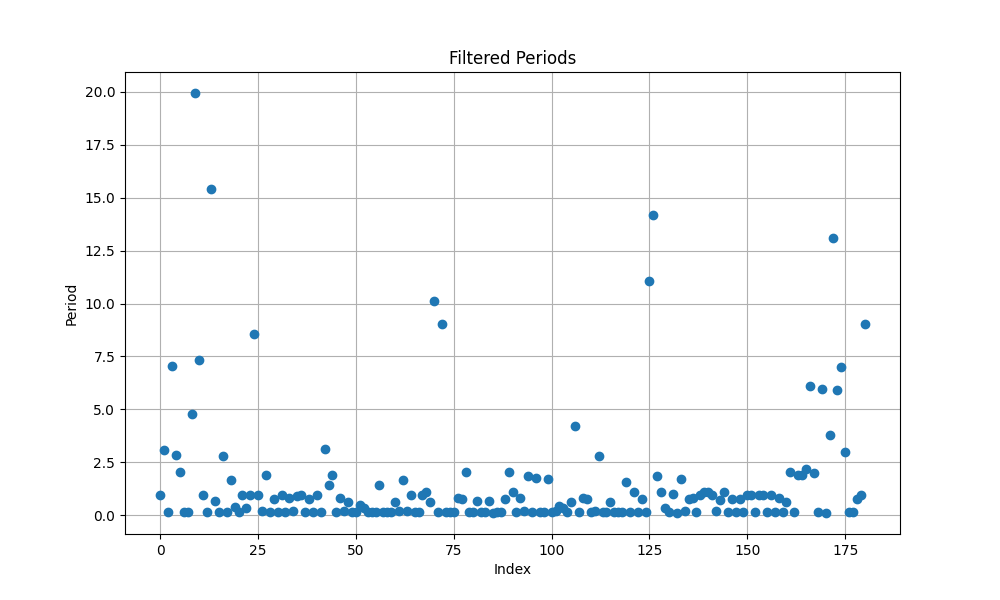

(np.float64(1.5298266979893245), np.float64(2.9005886651520276))

In [8]:
#Mean period and stuff, not required
periods_here = np.diff(observed_centers)

# Remove outliers from periods_here
mean_period = np.mean(periods_here)
std_period = np.std(periods_here)
filtered_periods = periods_here[(periods_here > mean_period - 2 * std_period) & (periods_here < mean_period + 2 * std_period)]

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)
filtered_periods = filtered_periods[(filtered_periods > mean_period - 2 * std_period) & (filtered_periods < mean_period + 2 * std_period)]

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)
filtered_periods = filtered_periods[(filtered_periods > mean_period - 2 * std_period) & (filtered_periods < mean_period + 2 * std_period)]

# Plot the filtered periods
plt.figure(figsize=(10, 6))
plt.plot(filtered_periods, marker='o', linestyle='none')
plt.title('Filtered Periods')
plt.xlabel('Index')
plt.ylabel('Period')
plt.grid(True)
plt.show()

mean_period = np.mean(filtered_periods)
std_period = np.std(filtered_periods)

mean_period, std_period

In [9]:
lightcurve_test = lightcurve_df[: int(avg_chunk_length * no_test_chunks)]

O_C_df = pd.DataFrame(
    {
    'E' : [x for x in range(int(-1.5 * all_chunk_count ), int(1.5 * all_chunk_count))]
    }
)

#Finding the T_0 for Event number 0
centre = (lightcurve_test['time'].min() + lightcurve_test['time'].max())/2
T_0_index = np.searchsorted(observed_centers, centre, side = 'right') + 1
print(f'T_0 index is {T_0_index}')

O_C_df['C'] = observed_centers[T_0_index] + O_C_df['E'] * fitted_period

# Insert observed_centers[i] at E = int((observed_centers[i] - observed_centers[T_0_index])/fitted_period), fill the rest with NaN
O_C_df['O'] = np.nan
for i in range(len(observed_centers)):
    E_value = int(round((observed_centers[i] - observed_centers[T_0_index]) / fitted_period))
    if E_value in O_C_df['E'].values:
        O_C_df.loc[O_C_df['E'] == E_value, 'O'] = observed_centers[i]

O_C_df['O-C'] = (O_C_df['O'] - O_C_df['C'])
# O_C_df = O_C_df.dropna(inplace=False)

def parabola(x, a, b, c):
    return a*(x**2) + b*x + c

def parabola2(x, a, b, c):
    return a*((x-b)**2) + c

another_O_C = O_C_df.dropna(inplace=False)
print("Number of points in O-C:", len(another_O_C))
mean_O_C = O_C_df['O-C'].mean()

T_0 index is 53
Number of points in O-C: 203


In [10]:
#Removing the outliers

stq_up_to_remove = 2
stq_down_to_remove= 2

s = O_C_df['O-C'].std()
print("Points removed = ", len(O_C_df[O_C_df['O-C'].apply(lambda x: True if (x-mean_O_C) > stq_up_to_remove*s else (True if (x-mean_O_C) < -stq_down_to_remove*s else False))]['O-C']))
O_C_df = O_C_df[O_C_df['O-C'].apply(lambda x: False if (x-mean_O_C) > stq_up_to_remove*s else (False if (x-mean_O_C) < -stq_down_to_remove*s else True))]

print("Points removed = ", len(another_O_C[another_O_C['O-C'].apply(lambda x: True if (x-mean_O_C) > stq_up_to_remove*s else (True if (x-mean_O_C) < -stq_down_to_remove*s else False))]['O-C']))
another_O_C = another_O_C[another_O_C['O-C'].apply(lambda x: False if (x-mean_O_C) > stq_up_to_remove*s else (False if (x-mean_O_C) < -stq_down_to_remove*s else True))]


Points removed =  12
Points removed =  12


[ 1.07421769e-23 -4.13270178e-08 -2.00218597e-15]
fitted_period is 0.15587574989251077
P_dot is 1.0952341706668848e-11


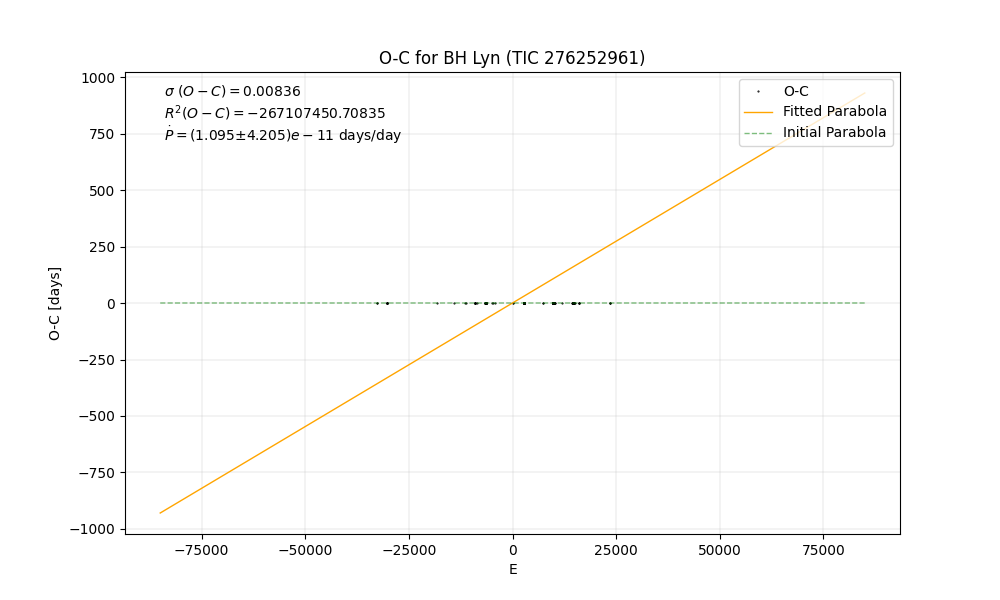

In [11]:
optimized_parameters_O_C_global = []

a = 0
b = 0
c = mean_O_C

initial_guess = [a, b, c]
optimized_parameters, covariance = optimize.curve_fit(parabola2, another_O_C['E'], another_O_C['O-C'], p0=initial_guess)

print(covariance[0])


fitted_parabola = parabola(O_C_df['E'], *optimized_parameters)
initial_parabola = parabola(O_C_df['E'], *initial_guess)


#Finding the R^2 value
residuals = O_C_df['O-C'] - fitted_parabola
ss_res = np.sum(residuals**2)
ss_tot = np.sum((O_C_df['O-C'] - O_C_df['O-C'].mean())**2)
r_squared = 1 - (ss_res / ss_tot)

optimized_parameters_O_C_global.append(optimized_parameters)

a = optimized_parameters[0]
print(f'fitted_period is {old_fitted_period}')
p_dot = (2 * a * 1/(old_fitted_period))
print(f'P_dot is {p_dot}')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(O_C_df['E'], O_C_df['O-C'], lw=0, marker='o', markersize=0.5, label = "O-C", color='black')
ax.plot(O_C_df['E'], fitted_parabola, lw=1, label = 'Fitted Parabola', color='orange')
ax.plot(O_C_df['E'], initial_parabola, lw=1, label = 'Initial Parabola', linestyle='--', alpha=0.5, color = 'green')
ax.legend(loc=1)
ax.set_title(f'O-C for {current_star}')
ax.set_xlabel('E')
ax.set_ylabel('O-C [days]')

O_C_std = O_C_df['O-C'].std()

p_dot_err = abs(p_dot * ((  (float(np.sqrt(covariance[0, 0]))/a)**2 + (global_periods_uncertainities[-1]/global_periods[-1])**2  )**(1/2)))

# Combine the values and adjust the format
base = p_dot / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Extract base
err_base = p_dot_err / 10**int(f"{p_dot:.3e}".split("e")[-1])  # Adjust error to same base
exponent = int(f"{p_dot:.3e}".split("e")[-1])  # Get exponent

# Format the result as required
formatted_result = f"({base:.3f}  ±  {err_base:.3f})e{exponent}"


plt.text(0.05, 0.95, r'$\sigma$' + f" $(O-C) = {O_C_std:.5f}$", transform=plt.gca().transAxes, fontsize=10)
plt.text(0.05, 0.90, f'$R^2 (O-C)= {r_squared:.5f}$', transform=plt.gca().transAxes, fontsize=10)

plt.text(0.05, 0.85, f'$\dot P = {formatted_result}$ days/day', transform=plt.gca().transAxes, fontsize=10)


ax.grid(True, linewidth = 0.2)

